In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
img_height, img_width = 128, 128
batch_size = 32

train_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.452771931886673, 0.46341875195503235, 0.4189051687717438], std=[0.15574541687965393, 0.13233783841133118, 0.17319917678833008])
])

valid_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.452771931886673, 0.46341875195503235, 0.4189051687717438], std=[0.15574541687965393, 0.13233783841133118, 0.17319917678833008])
])

train_data_dir = '/kaggle/input/tomatoleaf/tomato/train'
full_dataset = datasets.ImageFolder(train_data_dir, transform=train_transforms)

val_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

val_dataset.dataset.transform = valid_transforms

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

test_data_dir = '/kaggle/input/tomatoleaf/tomato/val'
test_dataset = datasets.ImageFolder(test_data_dir, transform=valid_transforms)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

class_names = full_dataset.classes
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [3]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128 -> 64

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64 -> 32

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 32 -> 16
        )
        # Вычисляем размер признакового вектора: 128 каналов, размер 16x16 (при входе 128x128)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (img_height // 8) * (img_width // 8), 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

num_classes = len(class_names)
model = CNN(num_classes).to(device)
print(model)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0

In [4]:
epochs = 20
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

best_val_loss = np.inf
patience = 5
trigger_times = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_loss = val_loss / total_val
    val_acc = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping")
            break


Epoch 1/20: Train Loss: 1.2354, Train Acc: 0.5705 | Val Loss: 0.5986, Val Acc: 0.8155
Epoch 2/20: Train Loss: 0.7484, Train Acc: 0.7390 | Val Loss: 0.4254, Val Acc: 0.8610
Epoch 3/20: Train Loss: 0.6066, Train Acc: 0.7861 | Val Loss: 0.3382, Val Acc: 0.8810
Epoch 4/20: Train Loss: 0.5371, Train Acc: 0.8109 | Val Loss: 0.3217, Val Acc: 0.8940
Epoch 5/20: Train Loss: 0.4847, Train Acc: 0.8306 | Val Loss: 0.3769, Val Acc: 0.8685
Epoch 6/20: Train Loss: 0.4212, Train Acc: 0.8565 | Val Loss: 0.3035, Val Acc: 0.8905
Epoch 7/20: Train Loss: 0.3884, Train Acc: 0.8691 | Val Loss: 0.3911, Val Acc: 0.8675
Epoch 8/20: Train Loss: 0.3589, Train Acc: 0.8720 | Val Loss: 0.2628, Val Acc: 0.9100
Epoch 9/20: Train Loss: 0.3034, Train Acc: 0.8949 | Val Loss: 0.3039, Val Acc: 0.8990
Epoch 10/20: Train Loss: 0.2864, Train Acc: 0.8960 | Val Loss: 0.2540, Val Acc: 0.9165
Epoch 11/20: Train Loss: 0.2866, Train Acc: 0.9006 | Val Loss: 0.2494, Val Acc: 0.9140
Epoch 12/20: Train Loss: 0.2377, Train Acc: 0.9157 |

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch  # Assuming you're using PyTorch

# Load the best saved model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()  # Set the model to evaluation mode

all_preds = []
all_labels = []

# Disable gradient calculation (inference mode)
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted class
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)


/tmp/ipykernel_10/3170780546.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


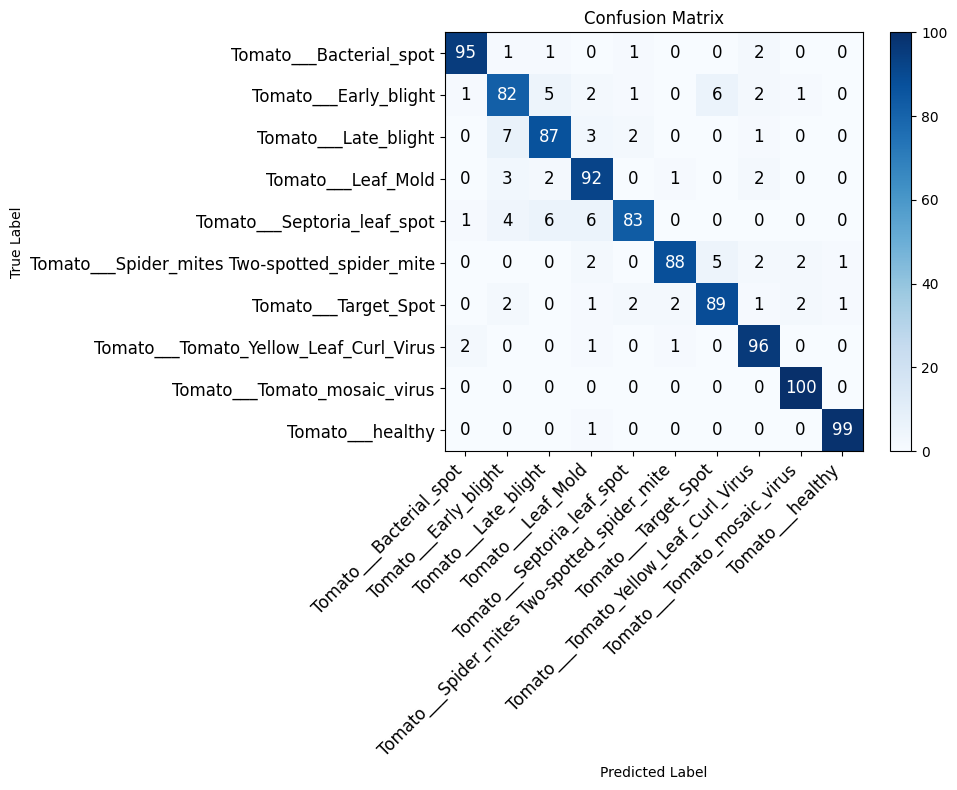

In [6]:
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # Set the title and axis labels
    ax.set(title=title, ylabel='True Label', xlabel='Predicted Label')

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45, ha="right", fontsize=12)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=12)

    # Adjust layout to avoid cutting off axis labels
    fig.tight_layout()
    plt.show()

# Visualize the original (non-normalized) confusion matrix
plot_confusion_matrix(cm, classes=class_names, normalize=False, title='Confusion Matrix')


In [7]:
from sklearn.metrics import classification_report

# Print a detailed classification report (precision, recall, f1-score, and support for each class)
print(classification_report(all_labels, all_preds, target_names=class_names))


                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.96      0.95      0.95       100
                        Tomato___Early_blight       0.83      0.82      0.82       100
                         Tomato___Late_blight       0.86      0.87      0.87       100
                           Tomato___Leaf_Mold       0.85      0.92      0.88       100
                  Tomato___Septoria_leaf_spot       0.93      0.83      0.88       100
Tomato___Spider_mites Two-spotted_spider_mite       0.96      0.88      0.92       100
                         Tomato___Target_Spot       0.89      0.89      0.89       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.91      0.96      0.93       100
                 Tomato___Tomato_mosaic_virus       0.95      1.00      0.98       100
                             Tomato___healthy       0.98      0.99      0.99       100

                                     accu

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0879112..1.5517813].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8952967..1.3419957].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1323608..1.6827753].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0286453..1.6235093].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0879112..1.8161645].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85084724..1.6827753].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.05827

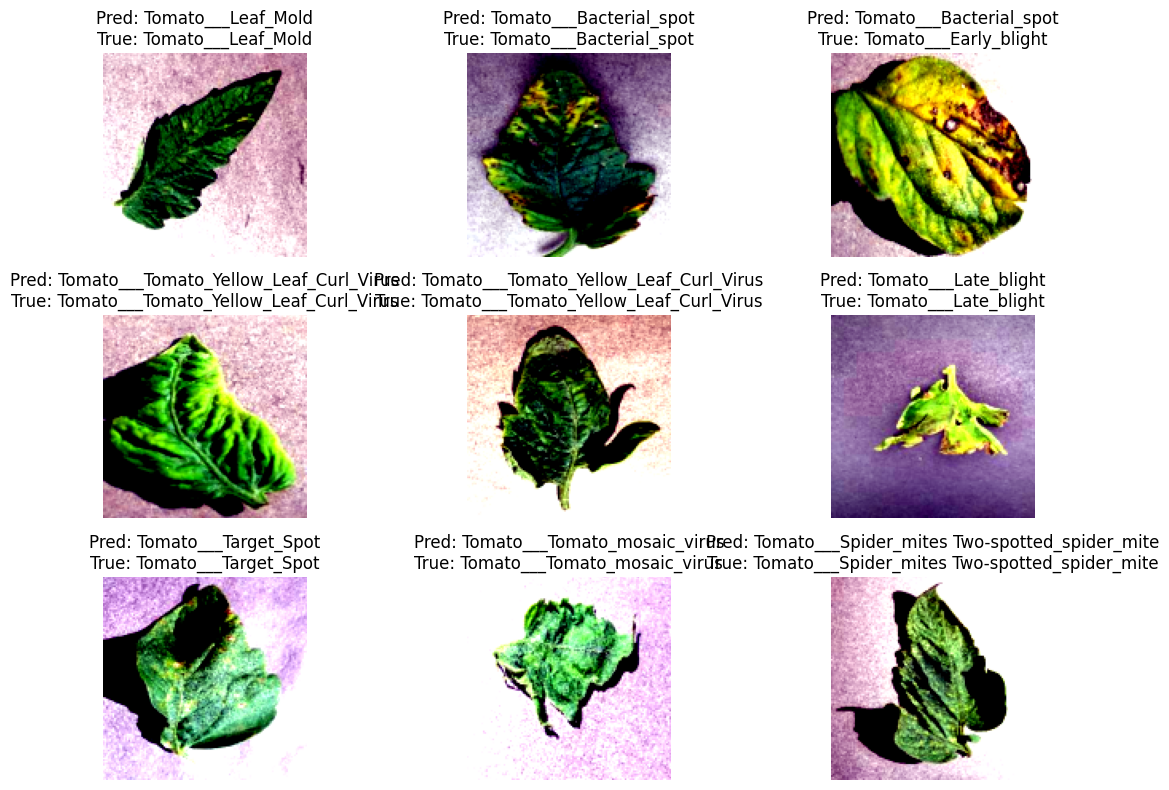

In [8]:
import random

# Function to denormalize an image (return to range [0, 1])
def denormalize(img):
    img = img * 0.5 + 0.5  # reverse normalization with mean=0.5, std=0.5
    return img

# Select a few random images from the test dataset
model.eval()
plt.figure(figsize=(12, 8))
num_images = 9
for i in range(num_images):
    idx = random.randint(0, len(test_dataset) - 1)
    img, label = test_dataset[idx]
    
    # Add batch dimension and move to device
    img_input = img.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_input)
        _, pred = torch.max(output, 1)
    
    pred_class = class_names[pred.item()]
    true_class = class_names[label]
    
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.transpose(denormalize(img).numpy(), (1, 2, 0)))
    plt.title(f"Pred: {pred_class}\nTrue: {true_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()
